## Group Project Report
# An Exploratory Analysis Into Diabetes
#### Group 21: Aiko Sumarno, Yoona Wang, Jerry Jin, Daniel Chou

## Introduction:

Diabetes is a severe and chronic ailment that significantly affects the lives and welfare of individuals, families, and communities. Globally, 10% of people have diabetes, and it ranks among the leading causes of death in adults (Saeedi et al., 2019). In 2019, it was reported that 8.8% of Canadians have diabetes, and approximately 549 new cases are diagnosed daily (LeBlanc et al., 2019). Several factors contribute to the development of diabetes in an individual, including gender, age, HbA1c levels, BMI, and blood glucose levels (Wang et al., 2021).

We will analyze a dataset of 100,000 diabetic and non-diabetic patients' medical history records from [Kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset). The primary source of this dataset is Electronic Health records by healthcare providers. The dataset contains the following variables: 
* gender = male / female
* age 
* hypertension = yes / no
* heart_disease = yes / no
* smoking_history = never / no info / current / former / ever / never / not current
* bmi = body mass index
* HbA1c_level = Hemoglobin A1C level
* blood_glucose_level = amount of glucose in the blood
* diabetes = diabetic / non-diabetic

Through our project, we aim to find the relationship between the variables and being diabetic. **Can age, BMI, HbA1C level and blood glucose level predict if a patient has diabetes?**

*Expected Outcome:* We expect that age, BMI, Hemoglobin A1C level and blood glucose level are significant indicators between individuals who are diabetic and non-diabetic. Hence, it provides a valuable basis for classification that can be used for early detection of diabetes.

## Methods & Results:
***

### Preliminary Exploratory Data Analysis:

In [1]:
 install.packages("themis") # library themis is neeeded to upsample the data

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [15]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(themis)

options(repr.matrix.max.rows = 10)


#### **1. Read and Tidy Data**

Based on previous literature, we have decided to use the **age**, **bmi**, **HbA1c_level**, **blood_glucose_level** and **diabetes** as the variables for our analysis. 

To tidy and modify our data, we use the `mutate` and `as_factor` functions to convert the diabetes diagnosis to a factor type so that we can use it as a categorical variable in our analysis. We also used `fct_recode` to give our variables more informative names. Then, we used the `select` function to create a data frame with only the columns we wanted to analyze.


In [16]:
#diabetes <- read_csv("data/diabetes.csv")
# to demonstrate that the dataset is readable from web to R
# Our first step is to download the dataset from Kaggle since we couldn't access the raw data
# Then, we uploaded it to Github repostitory to access the raw data
# Eventually, using read_csv to access the raw data
diabetes <- read_csv("https://raw.githubusercontent.com/aikosumarno/dsci-100-2023w2-group-21/main/data/diabetes.csv")
head(diabetes)

Rows: 100000 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, smoking_history
dbl (7): age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_l...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender age hypertension heart_disease smoking_history bmi   HbA1c_level
1 Female 80  0            1             never           25.19 6.6        
2 Female 54  0            0             No Info         27.32 6.6        
3 Male   28  0            0             never           27.32 5.7        
4 Female 36  0            0             current         23.45 5.0        
5 Male   76  1            1             current         20.14 4.8        
6 Female 20  0            0             never           27.32 6.6        
  blood_glucose_level diabetes
1 140                 0       
2  80                 0       
3 158                 0       
4 155                 0       
5 155                 0       
6  85                 0

In [17]:
diabetes <- diabetes |>
              mutate(diabetes = as_factor(diabetes)) |>
              mutate(diabetes = fct_recode(diabetes, "diabetic" = "1", "non-diabetic" = "0")) |> 
              mutate(hypertension = as_factor(hypertension)) |> 
              mutate(hypertension = fct_recode(hypertension, "yes" = "1", "no" = "0")) |> 
              mutate(heart_disease = as_factor(heart_disease)) |> 
              mutate(heart_disease = fct_recode(heart_disease, "yes" = "1", "no" = "0")) 
head(diabetes)

gender age hypertension heart_disease smoking_history bmi   HbA1c_level
1 Female 80  no           yes           never           25.19 6.6        
2 Female 54  no           no            No Info         27.32 6.6        
3 Male   28  no           no            never           27.32 5.7        
4 Female 36  no           no            current         23.45 5.0        
5 Male   76  yes          yes           current         20.14 4.8        
6 Female 20  no           no            never           27.32 6.6        
  blood_glucose_level diabetes    
1 140                 non-diabetic
2  80                 non-diabetic
3 158                 non-diabetic
4 155                 non-diabetic
5 155                 non-diabetic
6  85                 non-diabetic

In [19]:
diabetes_tidy <- diabetes |> 
                    select(-gender, - hypertension, -heart_disease, -smoking_history)
head(diabetes_tidy)

age bmi   HbA1c_level blood_glucose_level diabetes    
1 80  25.19 6.6         140                 non-diabetic
2 54  27.32 6.6          80                 non-diabetic
3 28  27.32 5.7         158                 non-diabetic
4 36  23.45 5.0         155                 non-diabetic
5 76  20.14 4.8         155                 non-diabetic
6 20  27.32 6.6          85                 non-diabetic

#### **2. Summarize Data** 

First, the `set.seed` function is used to ensure that we have reproducible results.

Since our dataset is very large with 100,000 observations, we used the `sample_n` function to take a random subset of 10,000 observations.

Then, the data is split into **75% for training** and **25% for testing** using the `initial_split` function.

To summarize the training data, we counted the percentage of patients diagnosed with diabetes using the `group_by` and `summarize` functions. We also used `map_df` to calculate and compare the average value of each predictor between diabetic and non-diabetic patients. 

In [20]:
set.seed(123) # ensures replicability
diabetes_subset <- sample_n(diabetes_tidy, size = 10000) 
diabetes_subset

age  bmi   HbA1c_level blood_glucose_level diabetes    
1     46   27.32 4.0         200                 non-diabetic
2     65   27.32 6.1         155                 non-diabetic
3     67   28.84 5.7         160                 diabetic    
4     53   27.32 5.7         130                 non-diabetic
5     17   24.32 6.6         145                 non-diabetic
⋮     ⋮    ⋮     ⋮           ⋮                   ⋮           
9996  40.0 21.50 6.0         160                 non-diabetic
9997  36.0 27.32 6.5         200                 non-diabetic
9998   1.8 19.87 3.5         126                 non-diabetic
9999  44.0 29.08 6.1         100                 non-diabetic
10000 62.0 27.32 5.0          85                 non-diabetic

In [21]:
set.seed(123) ## ensures replicability
diabetes_split <- initial_split(diabetes_subset, prop = 0.75, strata = diabetes) 
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)

In [22]:
glimpse(diabetes_training)

Rows: 7,500
Columns: 5
$ age                 <dbl> 46, 65, 67, 17, 80, 27, 75, 34, 40, 80, 3, 80, 53,…
$ bmi                 <dbl> 27.32, 27.32, 28.84, 24.32, 27.32, 22.32, 27.32, 3…
$ HbA1c_level         <dbl> 4.0, 6.1, 5.7, 6.6, 5.0, 3.5, 6.5, 4.5, 6.0, 4.5, …
$ blood_glucose_level <dbl> 200, 155, 160, 145, 158, 140, 140, 100, 140, 100, …
$ diabetes            <fct> non-diabetic, non-diabetic, diabetic, non-diabetic…


In [23]:
glimpse(diabetes_testing)

Rows: 2,500
Columns: 5
$ age                 <dbl> 53.00, 40.00, 42.00, 58.00, 66.00, 12.00, 66.00, 9…
$ bmi                 <dbl> 27.32, 25.92, 30.98, 40.67, 26.51, 26.53, 30.68, 2…
$ HbA1c_level         <dbl> 5.7, 4.8, 5.0, 6.0, 3.5, 4.0, 8.8, 6.5, 6.1, 4.0, …
$ blood_glucose_level <dbl> 130, 90, 100, 140, 140, 126, 220, 100, 126, 155, 8…
$ diabetes            <fct> non-diabetic, non-diabetic, non-diabetic, non-diab…


In [24]:
cat("Table 1: Number and Percentage of Patients that Diagnosed with Diabetes\n")
diabetes_proportions <- diabetes_training |>
                          group_by(diabetes) |>
                          summarize(count = n()) |>
                          mutate(percent = 100*count/nrow(diabetes_training))

diabetes_proportions
#From Table 1, we obtained that the percentage of patients with diabetes in the dataset

Table 1: Number and Percentage of Patients that Diagnosed with Diabetes


diabetes     count percent  
1 non-diabetic 6862  91.493333
2 diabetic      638   8.506667

In [25]:
cat("Table 2: Average Predictor Values\n")
diabetes_mean <- diabetes_training |>
                    select(-diabetes) |>
                    map_df(mean) 
diabetes_mean

Table 2: Average Predictor Values


age      bmi     HbA1c_level blood_glucose_level
1 42.02384 27.2511 5.538187    137.5664

In [26]:
cat("Table 3: Average Predictor Values for Diabetic and Non-Diabetic Patients")
comparison <- diabetes_training |>
                group_by(diabetes) |>
                summarize(avg_age = mean(age),
                          avg_bmi = mean(bmi), 
                          avg_HbA1c_level = mean(HbA1c_level), 
                          avg_blood_glucose_level = mean(blood_glucose_level))
comparison

Table 3: Average Predictor Values for Diabetic and Non-Diabetic Patients

diabetes     avg_age  avg_bmi  avg_HbA1c_level avg_blood_glucose_level
1 non-diabetic 40.34360 26.80349 5.409239        132.3798               
2 diabetic     60.09561 32.06531 6.925078        193.3511

#### **3. Exploratory Data Visualization**

To compare the distributions of each predictor variable across diabetic and non-diabetic patients, we used the `ggplot` and `geom_histogram` functions to plot histograms. `facet_grid` was also used to stack the plots above each other for easier comparative analysis. 

To determine the distribution of patients according to their blood glucose level and HbA1C level, we also used the `geom_point` function to create a scatter plot. 

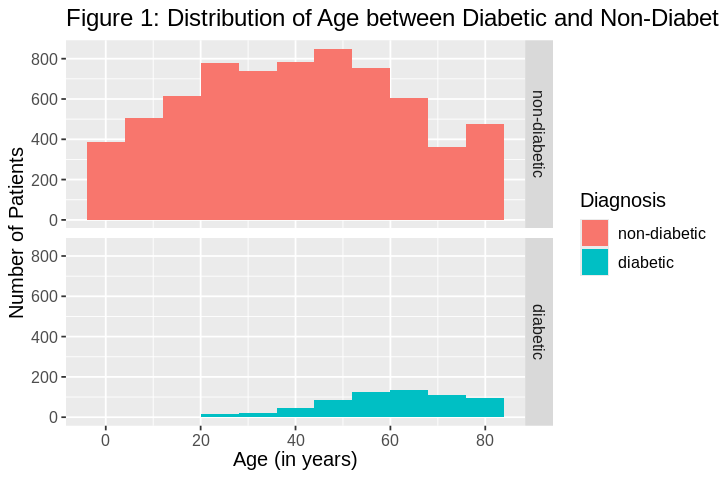

In [30]:
options(repr.plot.width = 6, repr.plot.height = 4)
age_plot <- diabetes_training |>
                ggplot(aes(x = age, fill = diabetes)) +
                geom_histogram(binwidth = 8) +
                facet_grid(rows = vars(diabetes)) +
                labs(x = "Age (in years)", y = "Number of Patients", fill = "Diagnosis") +
                ggtitle("Figure 1: Distribution of Age between Diabetic and Non-Diabetic Patients") +
                theme(text = element_text(size = 12))
age_plot

Non-diabetic patients have a consistent distribution over the age range, with a slight decrease in the oldest age group. There is an increase in diabetic patients with age.

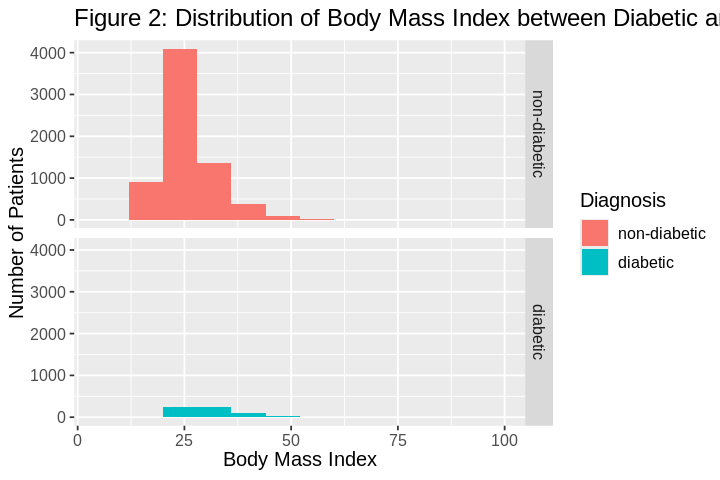

In [31]:
bmi_plot <- diabetes_training |>
                ggplot(aes(x = bmi, fill = diabetes)) +
                geom_histogram(binwidth = 8) +
                facet_grid(rows = vars(diabetes)) +
                labs(x = "Body Mass Index", y = "Number of Patients", fill = "Diagnosis") +
                ggtitle("Figure 2: Distribution of Body Mass Index between Diabetic and Non-Diabetic Patients") +
                theme(text = element_text(size = 12))
bmi_plot

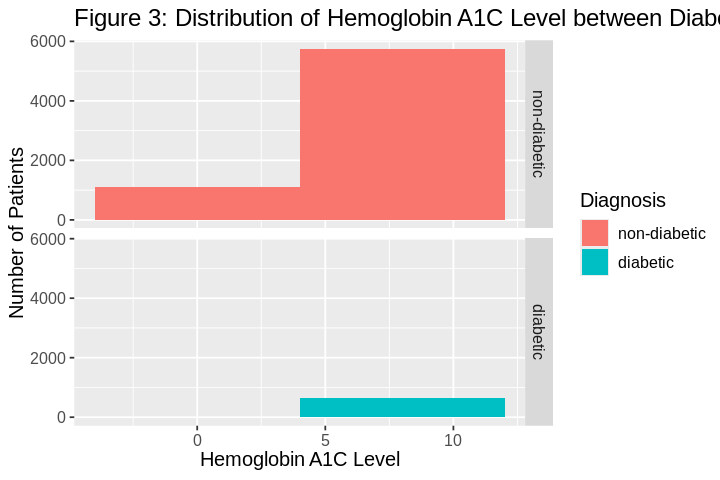

In [32]:
HbA1c_level_plot <- diabetes_training |>
                        ggplot(aes(x = HbA1c_level, fill = diabetes)) +
                        geom_histogram(binwidth = 8) +
                        facet_grid(rows = vars(diabetes)) +
                        labs(x = "Hemoglobin A1C Level", y = "Number of Patients", fill = "Diagnosis") +
                        ggtitle("Figure 3: Distribution of Hemoglobin A1C Level between Diabetic and Non-Diabetic Patients") +
                        theme(text = element_text(size = 12))
HbA1c_level_plot

Diabetics have haemoglobin A1C levels of ~4% or higher. 

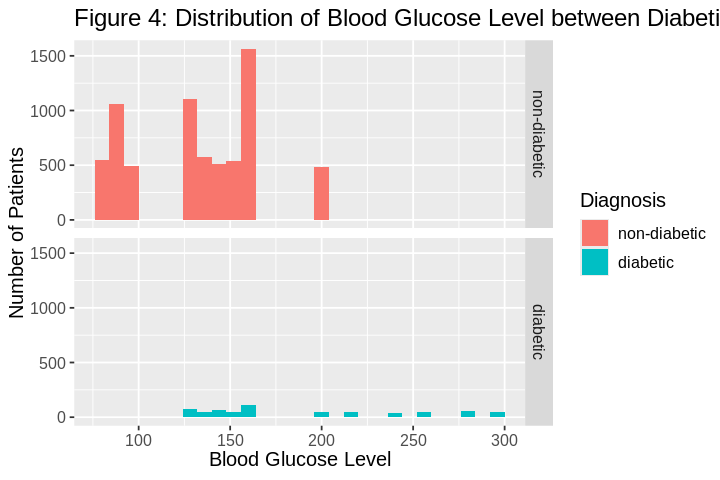

In [33]:
blood_glucose_level_plot <- diabetes_training |>
                            ggplot(aes(x = blood_glucose_level, fill = diabetes)) +
                            geom_histogram(binwidth = 8) +
                            facet_grid(rows = vars(diabetes)) +
                            labs(x = "Blood Glucose Level", y = "Number of Patients", fill = "Diagnosis") +
                            ggtitle("Figure 4: Distribution of Blood Glucose Level between Diabetic and Non-Diabetic Patients") +
                            theme(text = element_text(size = 12))
blood_glucose_level_plot

Non-diabetic patients' blood glucose levels are concentrated at lower levels, while diabetic patients have a greater distribution with many spikes, implying that they experience a wider range of blood glucose levels, including highly elevated levels.

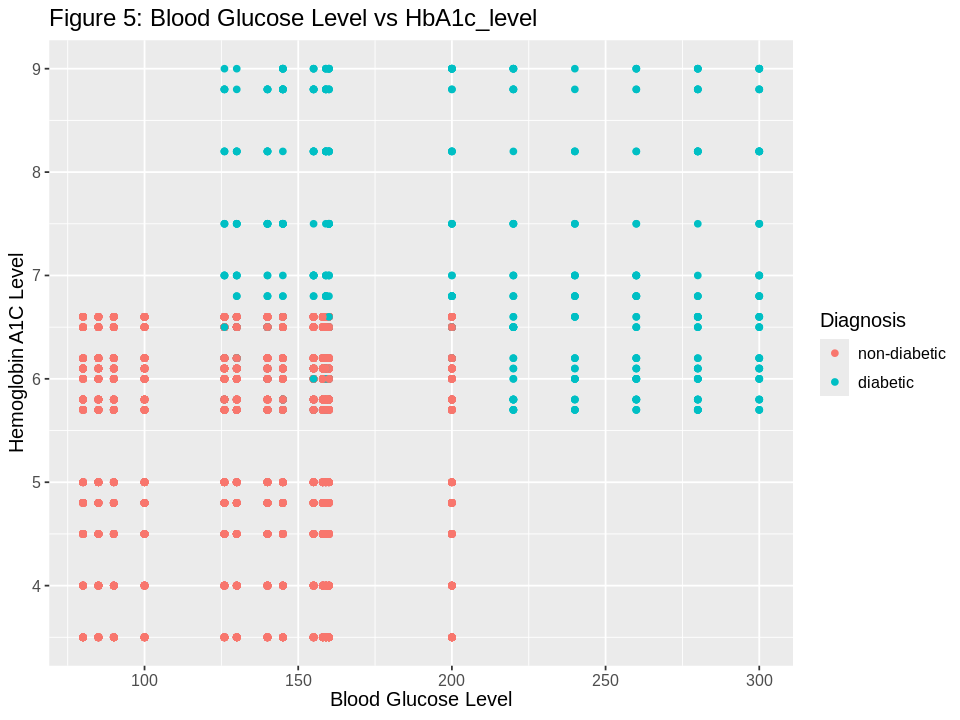

In [36]:
options(repr.plot.width = 8, repr.plot.height = 6)
blood_vs_HbA1c_plot <- diabetes_training |>
                            ggplot(aes(x = blood_glucose_level, y = HbA1c_level, color = diabetes)) +
                            geom_point() +
                            labs(x = "Blood Glucose Level", y = "Hemoglobin A1C Level", color = "Diagnosis") +
                            ggtitle("Figure 5: Blood Glucose Level vs HbA1c_level") +
                            theme(text = element_text(size = 12))
blood_vs_HbA1c_plot

The clusters indicate a clear distinction between non-diabetic and diabetic patients. There's a higher chance of being diabetic if an individual has a high blood_glucose_level, HbA1c_level, or both. 

***
### KNN Classification Algorithm

To investigate our research question, we will use the **K-Nearest Neighbour** classification algorithm from the `tidymodels` package to predict a categorical value (diagnosis) from our predictors. The predictor variables used in our model are **age**, **BMI**, **blood glucose level** and **HbA1c level**. Our categorical variable will be the **diabetes** column which indicates whether or not the patient is diabetic. **5-fold cross-validation** was used to tune our model and determine the optimal k-value that prevents underfitting and overfitting. 

To ensure the replicability of our results, we use the `set.seed` function in all cells that involve randomisation. 

First, we used the `recipe` function on the training data to specify the predictor variables and label. Because our dataset was heavily unbalanced, we also used the `step_upample` function to upsample our data to ensure that we have an even ratio of diabetic and non-diabetic observations. 

Just as a preliminary analysis, we created a KNN model with the number of neighbours set to 5. Here, we used the `step_center` and `step_scale` functions to standardize all our predictors. Then, we used a `workflow` to train our model before using our testing data to predict and test the accuracy of our model using precision and recall. 

After evaluating the performance of our initial model, we decided to tune our classifier. We used 5-fold cross-validation to split the training data into 5 chunks, trained each chunk with different K nearest neighbours models and evaluated their accuracy using the `collect_metrics` function. Then, we tuned our KNN model and tried out 30 possible k values using `tune_grid` function. Lastly, we plotted the accuracy of each model on a line plot using the `geom_line` function before determining the optimal k value with the highest level of accuracy.

From the results of our cross-validation, we determined that the **optimal value of k for our model would be 1**. However, because we were worried that there may be issues of overfitting, we decided to try out a few other values for k. Looking at the line chart, we saw 3 significant drops in our accuracy. Hence, we decided to choose the k value from each of these drops for our other two models. At the end, we created and analysed **3 models with the k values of 1, 3 and 5**. 

To measure the performance of our classifier we used a **confusion matrix** and visualized the results using a **pie chart**. 


In [37]:
set.seed(123) 

diabetes_recipe <- recipe(diabetes ~ ., data = diabetes_training) |>
              step_upsample(diabetes, over_ratio = 1, skip = FALSE) |>
              prep()

diabetes_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Training information 

Training data contained 7500 data points and no incomplete rows.



── Operations 

• Up-sampling based on: diabetes | Trained



In [38]:
# Since our data set is imbalance (there are more non-diabetic than diabetic),
# we will oversample the rare class to give it more voting power in the KNN algorithm.

upsampled_diabetes <- bake(diabetes_recipe, diabetes_training)

upsampled_diabetes |>
  group_by(diabetes) |>
  summarize(n = n())

diabetes     n   
1 non-diabetic 6862
2 diabetic     6862

#### **1. Exploratory Analysis**

In [39]:
set.seed(123)

# create the K-NN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
              set_engine("kknn") |>
              set_mode("classification")

# Since our data set is imbalance (there are more non-diabetic than diabetic),
# we will oversample the rare class to give it more voting power in the KNN algorithm.
# We will also standardize our data so that our predictors are weighed equally. 
diabetes_recipe <- recipe(diabetes ~ ., data = upsampled_diabetes) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) 
                    # if i upsample the training data, it creates an error when I test the classifier on the testing data

knn_fit <- workflow() |>
            add_recipe(diabetes_recipe) |> 
            add_model(knn_spec) |> 
            fit(data = upsampled_diabetes)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.03424658
Best kernel: rectangular
Best k: 5

In [40]:
diabetes_test_predictions <- predict(knn_fit, diabetes_testing) |>
                                bind_cols(diabetes_testing)
head(diabetes_test_predictions)

.pred_class  age bmi   HbA1c_level blood_glucose_level diabetes    
1 non-diabetic 53  27.32 5.7         130                 non-diabetic
2 non-diabetic 40  25.92 4.8          90                 non-diabetic
3 non-diabetic 42  30.98 5.0         100                 non-diabetic
4 diabetic     58  40.67 6.0         140                 non-diabetic
5 non-diabetic 66  26.51 3.5         140                 non-diabetic
6 non-diabetic 12  26.53 4.0         126                 non-diabetic

#### Evaluate Performance

In [41]:
accuracy <- diabetes_test_predictions |> 
                metrics(truth = diabetes, estimate = .pred_class) |> 
                filter(.metric == "accuracy") |> 
                select(.estimate) |> 
                pull() 
accuracy

[1] 0.914

In [42]:
diabetes_test_predictions |> pull(diabetes) |> levels()

[1] "non-diabetic" "diabetic"

In [43]:
diabetes_test_predictions |> 
    precision(truth = diabetes, estimate = .pred_class, event_level = "second")

.metric   .estimator .estimate
1 precision binary     0.5124224

In [44]:
diabetes_test_predictions |> 
    recall(truth = diabetes, estimate = .pred_class, event_level = "second")

.metric .estimator .estimate
1 recall  binary     0.7399103

              Truth
Prediction     non-diabetic diabetic
  non-diabetic         2120       58
  diabetic              157      165

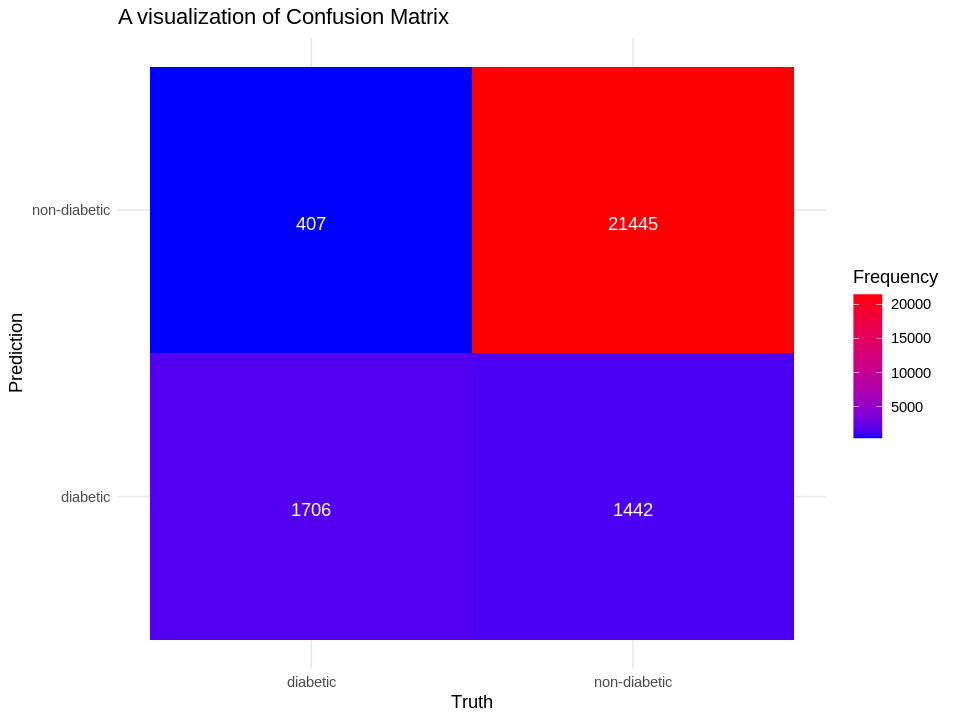

In [45]:
confusion <- diabetes_test_predictions |> 
                conf_mat(truth = diabetes, estimate = .pred_class)
confusion
conf_matrix <- data.frame(
  Prediction = rep(c('non-diabetic', 'diabetic'), times = 2),
  Truth = rep(c('non-diabetic', 'diabetic'), each = 2),
  Frequency = c(21445, 1442, 407, 1706)
)
ggplot(conf_matrix, aes(x = Truth, y = Prediction, fill = Frequency)) +
  geom_tile() +
  geom_text(aes(label = Frequency), vjust = 1.5, color = "white") +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "A visualization of Confusion Matrix", x = "Truth", y = "Prediction") +
  theme_minimal()
# from the visualization we can see that quite large chunk of non-diabetes patients were predicted as diabetic.

#### **2. Tuning the Classifier**

In [49]:
# we will use 5 fold cross validation to split the training data into 5 chunks
# we will then train each of the chunks with different K nearest neighbors models and evaluate their accuracy
diabetes_vfold <- vfold_cv(diabetes_training, v = 5, strata = diabetes)

In [50]:
diabetes_fit <- workflow() |>
                    add_recipe(diabetes_recipe) |> 
                    add_model(knn_spec) |> 
                    fit_resamples(resamples = diabetes_vfold) 

In [51]:
metrics <- diabetes_fit |> 
            collect_metrics()
metrics

.metric  .estimator mean      n std_err     .config             
1 accuracy binary     0.9632000 5 0.003115552 Preprocessor1_Model1
2 roc_auc  binary     0.9030403 5 0.010477927 Preprocessor1_Model1

In [52]:
tuned_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                    set_engine("kknn") |>
                    set_mode("classification")

In [53]:
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |> 
                add_recipe(diabetes_recipe) |> 
                add_model(tuned_knn_spec) |> 
                tune_grid(resamples = diabetes_vfold, grid = k_vals) |> 
                collect_metrics()

accuracies <- knn_results |> 
                filter(.metric == "accuracy")
accuracies 

neighbors .metric  .estimator mean      n std_err     .config              
1  1         accuracy binary     0.9480    5 0.003069564 Preprocessor1_Model01
2  2         accuracy binary     0.9480    5 0.003069564 Preprocessor1_Model02
3  3         accuracy binary     0.9596    5 0.002578544 Preprocessor1_Model03
4  4         accuracy binary     0.9596    5 0.002578544 Preprocessor1_Model04
5  5         accuracy binary     0.9632    5 0.003115552 Preprocessor1_Model05
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮           ⋮                    
26 26        accuracy binary     0.9617333 5 0.002072036 Preprocessor1_Model26
27 27        accuracy binary     0.9616000 5 0.002145797 Preprocessor1_Model27
28 28        accuracy binary     0.9616000 5 0.002145797 Preprocessor1_Model28
29 29        accuracy binary     0.9610667 5 0.001916014 Preprocessor1_Model29
30 30        accuracy binary     0.9610667 5 0.001916014 Preprocessor1_Model30

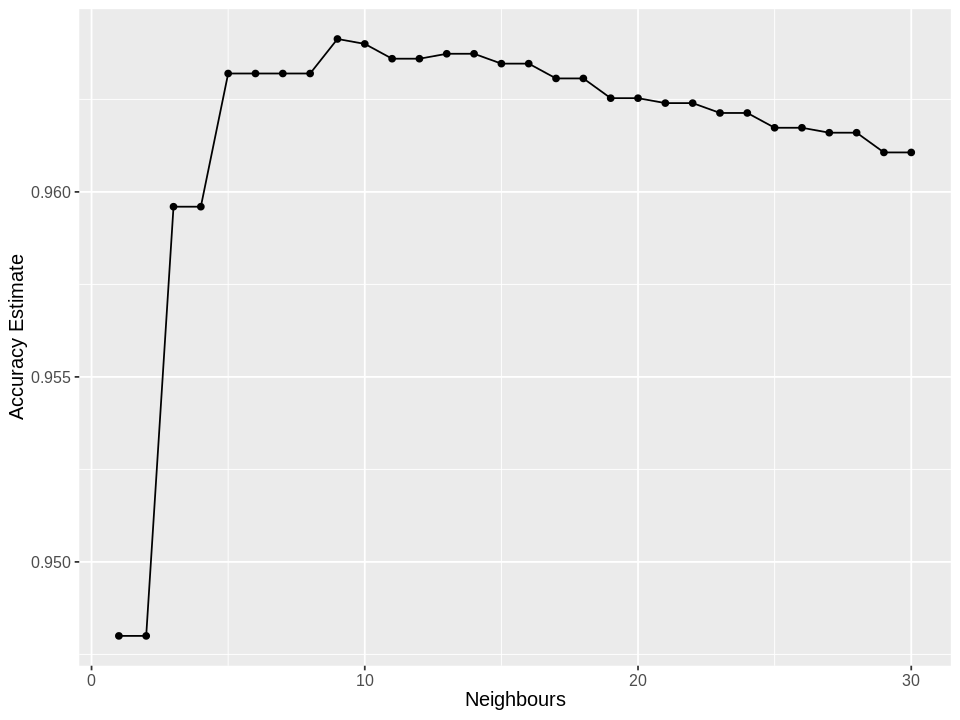

In [54]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbours", y = "Accuracy Estimate") + 
                    theme(text = element_text(size = 12))
accuracy_vs_k

In [55]:
best_k <- accuracies |> 
            arrange(desc(mean)) |> 
            head(1) |> 
            pull(neighbors)
best_k

[1] 9

.pred_class  age bmi   HbA1c_level blood_glucose_level diabetes    
1 non-diabetic 54  27.32 6.6          80                 non-diabetic
2 non-diabetic 28  27.32 5.7         158                 non-diabetic
3 non-diabetic 36  23.45 5.0         155                 non-diabetic
4 non-diabetic 20  27.32 6.6          85                 non-diabetic
5 non-diabetic 42  33.64 4.8         145                 non-diabetic
6 non-diabetic 53  27.32 6.1          85                 non-diabetic

              Truth
Prediction     non-diabetic diabetic
  non-diabetic        22317      595
  diabetic              570     1518

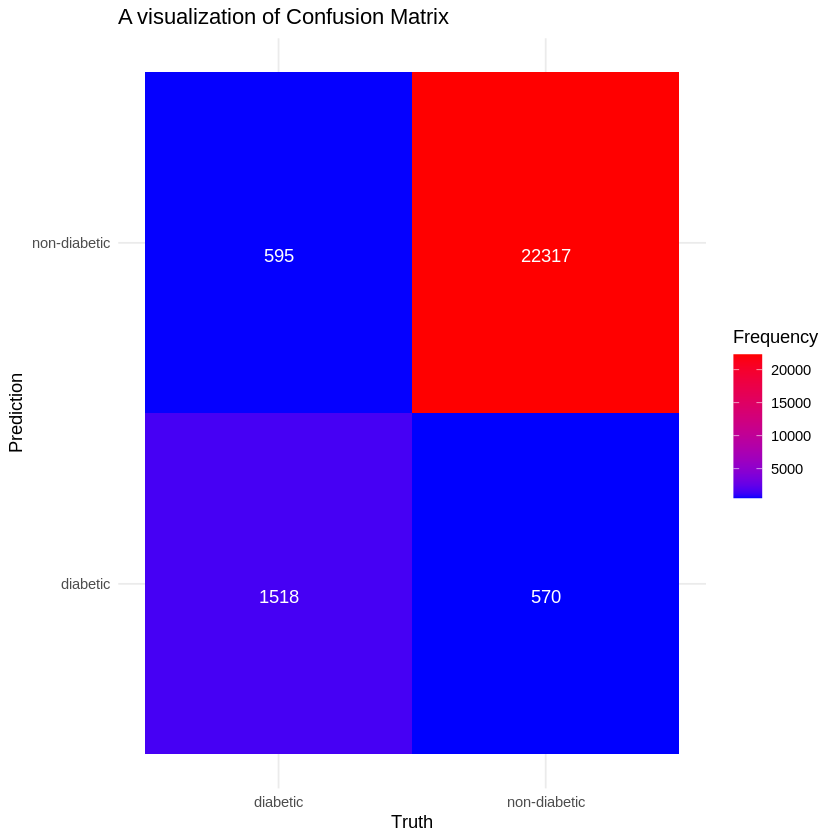

In [41]:
knn_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
               set_engine("kknn") |>
               set_mode("classification")
knn_fit_1 <- workflow() |>
             add_recipe(diabetes_recipe) |> 
             add_model(knn_spec_1) |> 
             fit(data = upsampled_diabetes)
diabetes_test_predictions_1 <- predict(knn_fit_1, diabetes_testing) |>
                                bind_cols(diabetes_testing)
head(diabetes_test_predictions_1)
confusion1 <- diabetes_test_predictions_1 |> 
                conf_mat(truth = diabetes, estimate = .pred_class)
confusion1
conf_matrix_1 <- data.frame(
  Prediction = rep(c('non-diabetic', 'diabetic'), times = 2),
  Truth = rep(c('non-diabetic', 'diabetic'), each = 2),
  Frequency = c(22317, 570, 595, 1518)
)
conf_matrix_plot_1 <- ggplot(conf_matrix_1, aes(x = Truth, y = Prediction, fill = Frequency)) +
  geom_tile() +
  geom_text(aes(label = Frequency), vjust = 1.5, color = "white") +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "A visualization of Confusion Matrix", x = "Truth", y = "Prediction") +
  theme_minimal()
conf_matrix_plot_1

In [42]:
knn_spec_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
               set_engine("kknn") |>
               set_mode("classification")
knn_fit_3 <- workflow() |>
             add_recipe(diabetes_recipe) |> 
             add_model(knn_spec_3) |> 
             fit(data = upsampled_diabetes)
diabetes_test_predictions_3 <- predict(knn_fit_3, diabetes_testing) |>
                                bind_cols(diabetes_testing)
head(diabetes_test_predictions_3)
confusion3 <- diabetes_test_predictions_3 |> 
                conf_mat(truth = diabetes, estimate = .pred_class)
confusion3

.pred_class  age bmi   HbA1c_level blood_glucose_level diabetes    
1 non-diabetic 54  27.32 6.6          80                 non-diabetic
2 non-diabetic 28  27.32 5.7         158                 non-diabetic
3 non-diabetic 36  23.45 5.0         155                 non-diabetic
4 non-diabetic 20  27.32 6.6          85                 non-diabetic
5 non-diabetic 42  33.64 4.8         145                 non-diabetic
6 non-diabetic 53  27.32 6.1          85                 non-diabetic

              Truth
Prediction     non-diabetic diabetic
  non-diabetic        21864      472
  diabetic             1023     1641

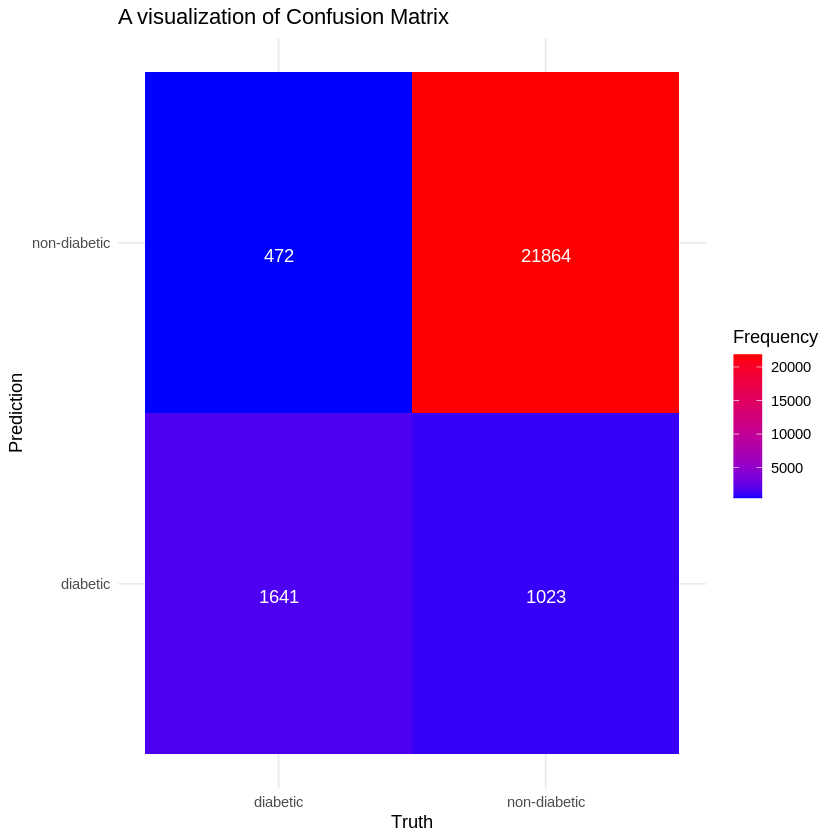

In [43]:
conf_matrix_3 <- data.frame(
  Prediction = rep(c('non-diabetic', 'diabetic'), times = 2),
  Truth = rep(c('non-diabetic', 'diabetic'), each = 2),
  Frequency = c(21864, 1023, 472, 1641) # not yet updated 
)
conf_matrix_plot_3 <- ggplot(conf_matrix_3, aes(x = Truth, y = Prediction, fill = Frequency)) +
  geom_tile() +
  geom_text(aes(label = Frequency), vjust = 1.5, color = "white") +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "A visualization of Confusion Matrix", x = "Truth", y = "Prediction") +
  theme_minimal()
conf_matrix_plot_3

In [44]:
knn_spec_5 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
               set_engine("kknn") |>
               set_mode("classification")
knn_fit_5 <- workflow() |>
             add_recipe(diabetes_recipe) |> 
             add_model(knn_spec_5) |> 
             fit(data = upsampled_diabetes)
diabetes_test_predictions_5 <- predict(knn_fit_5, diabetes_testing) |>
                                bind_cols(diabetes_testing)
head(diabetes_test_predictions_5)
confusion5 <- diabetes_test_predictions_5 |> 
                conf_mat(truth = diabetes, estimate = .pred_class)
confusion5

.pred_class  age bmi   HbA1c_level blood_glucose_level diabetes    
1 non-diabetic 54  27.32 6.6          80                 non-diabetic
2 non-diabetic 28  27.32 5.7         158                 non-diabetic
3 non-diabetic 36  23.45 5.0         155                 non-diabetic
4 non-diabetic 20  27.32 6.6          85                 non-diabetic
5 non-diabetic 42  33.64 4.8         145                 non-diabetic
6 non-diabetic 53  27.32 6.1          85                 non-diabetic

              Truth
Prediction     non-diabetic diabetic
  non-diabetic        21445      407
  diabetic             1442     1706

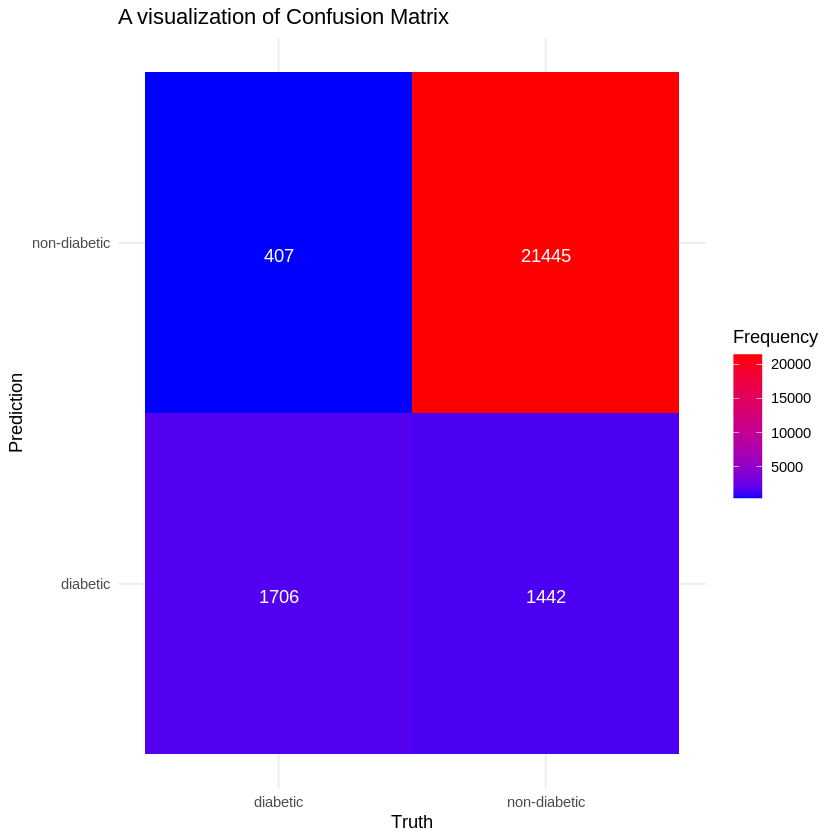

In [45]:
conf_matrix_5 <- data.frame(
  Prediction = rep(c('non-diabetic', 'diabetic'), times = 2),
  Truth = rep(c('non-diabetic', 'diabetic'), each = 2),
  Frequency = c(21445, 1442, 407, 1706) # not yet updated 
)
conf_matrix_plot_5 <- ggplot(conf_matrix_5, aes(x = Truth, y = Prediction, fill = Frequency)) +
  geom_tile() +
  geom_text(aes(label = Frequency), vjust = 1.5, color = "white") +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "A visualization of Confusion Matrix", x = "Truth", y = "Prediction") +
  theme_minimal()
conf_matrix_plot_5

.pred_class  age bmi   HbA1c_level blood_glucose_level diabetes    
1 non-diabetic 54  27.32 6.6          80                 non-diabetic
2 non-diabetic 28  27.32 5.7         158                 non-diabetic
3 non-diabetic 36  23.45 5.0         155                 non-diabetic
4 non-diabetic 20  27.32 6.6          85                 non-diabetic
5 non-diabetic 42  33.64 4.8         145                 non-diabetic
6 non-diabetic 53  27.32 6.1          85                 non-diabetic

              Truth
Prediction     non-diabetic diabetic
  non-diabetic        22328      596
  diabetic              559     1517

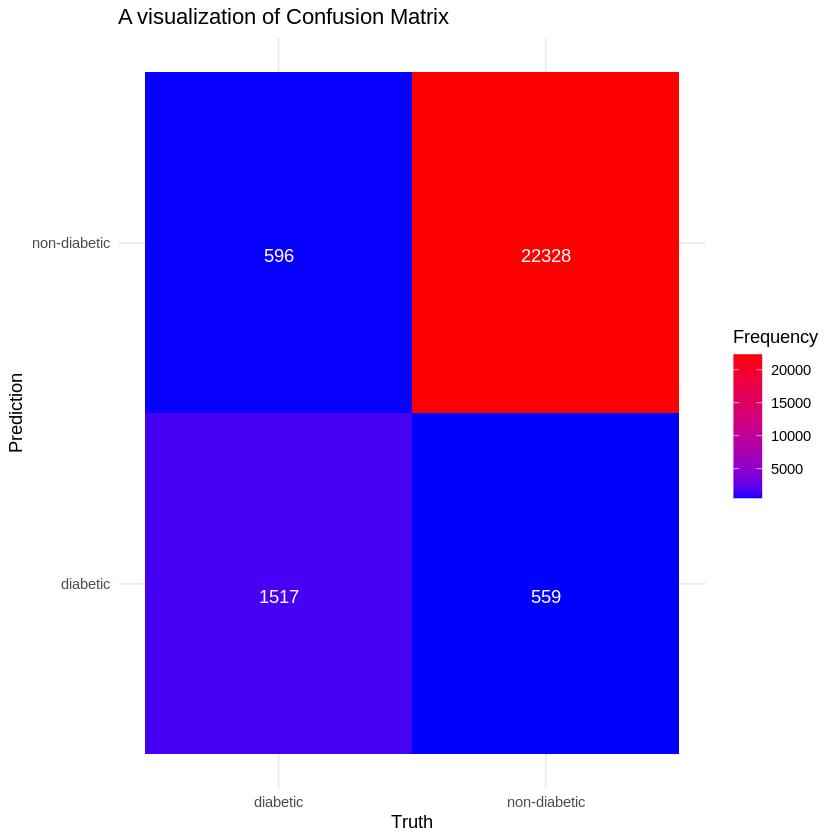

In [38]:
 knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
               set_engine("kknn") |>
               set_mode("classification")
 knn_fit_2 <- workflow() |>
             add_recipe(diabetes_recipe) |> 
             add_model(knn_spec_2) |> 
             fit(data = upsampled_diabetes)
diabetes_test_predictions <- predict(knn_fit_2, diabetes_testing) |>
                                bind_cols(diabetes_testing)
head(diabetes_test_predictions)
confusion <- diabetes_test_predictions |> 
                conf_mat(truth = diabetes, estimate = .pred_class)
confusion
conf_matrix <- data.frame(
  Prediction = rep(c('non-diabetic', 'diabetic'), times = 2),
  Truth = rep(c('non-diabetic', 'diabetic'), each = 2),
  Frequency = c(22328, 559, 596, 1517)
)
conf_matrix_plot <- ggplot(conf_matrix, aes(x = Truth, y = Prediction, fill = Frequency)) +
  geom_tile() +
  geom_text(aes(label = Frequency), vjust = 1.5, color = "white") +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "A visualization of Confusion Matrix", x = "Truth", y = "Prediction") +
  theme_minimal()
conf_matrix_plot

### Data Visualization:

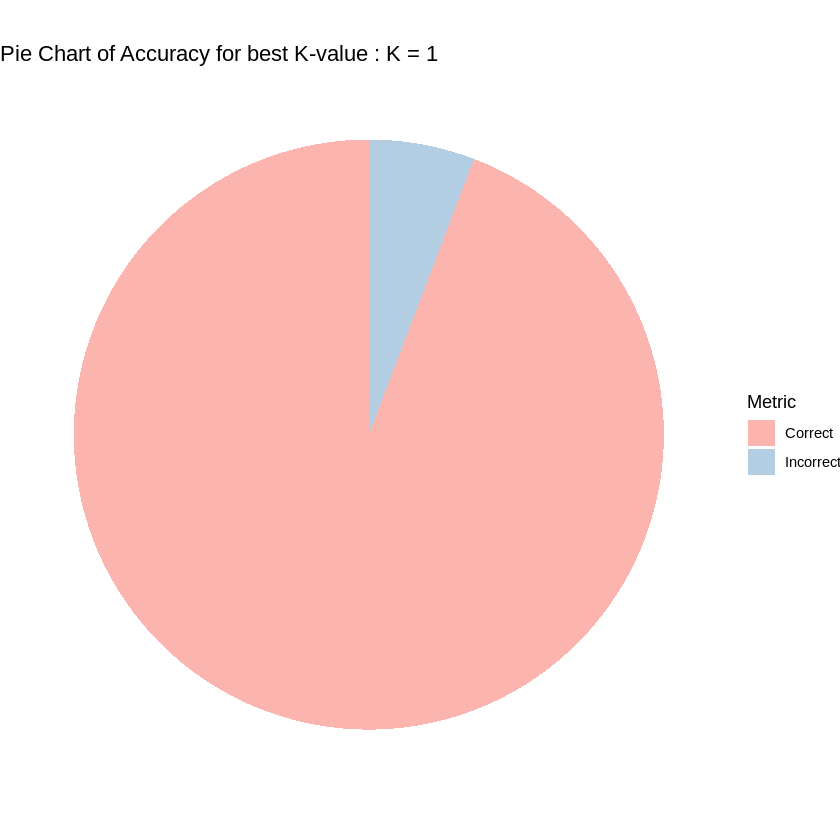

In [47]:
data_k_1 <- data.frame(
  Metric = c("Correct", "Incorrect"),
  Value = c(0.9419333, 1 - 0.9419333)
)


# Create a pie chart
k1_accuracy <- ggplot(data_k_1, aes(x = "", y = Value, fill = Metric)) +
                  geom_bar(stat = "identity", width = 1) +
                  coord_polar(theta = "y") +
                  theme_void() +
                  scale_fill_brewer(palette = "Pastel1") +
                  labs(title = "Pie Chart of Accuracy for best K-value : K = 1")
k1_accuracy

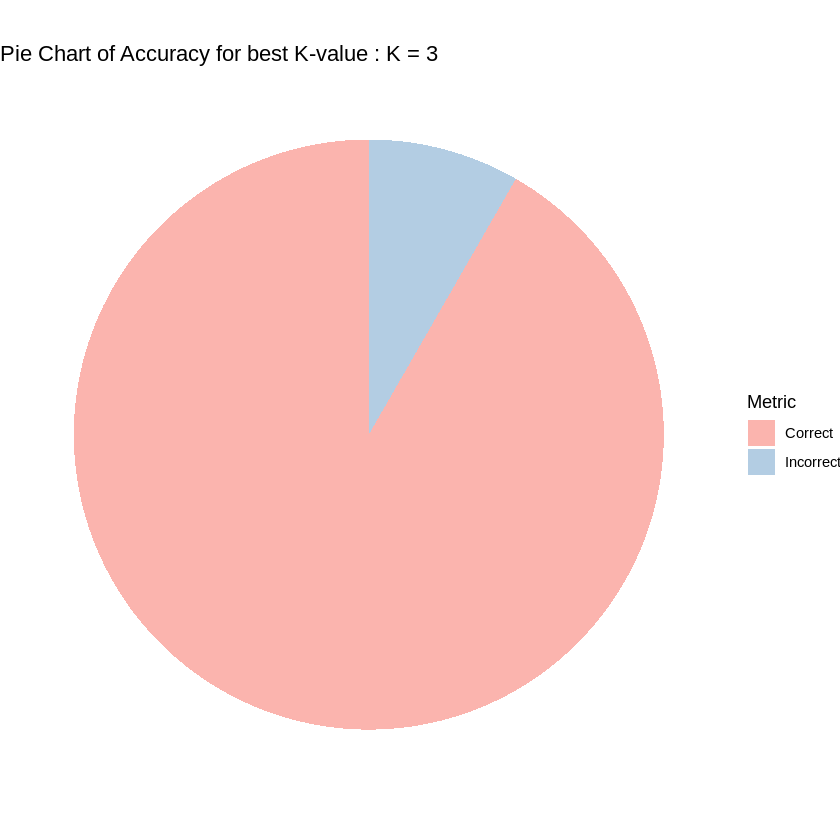

In [49]:
data_k_3 <- data.frame(
  Metric = c("Correct", "Incorrect"),
  Value = c(0.9169332, 1 - 0.9169332)
)


# Create a pie chart
k3_accuracy <- ggplot(data_k_3, aes(x = "", y = Value, fill = Metric)) +
                  geom_bar(stat = "identity", width = 1) +
                  coord_polar(theta = "y") +
                  theme_void() +
                  scale_fill_brewer(palette = "Pastel1") +
                  labs(title = "Pie Chart of Accuracy for best K-value : K = 3")
k3_accuracy

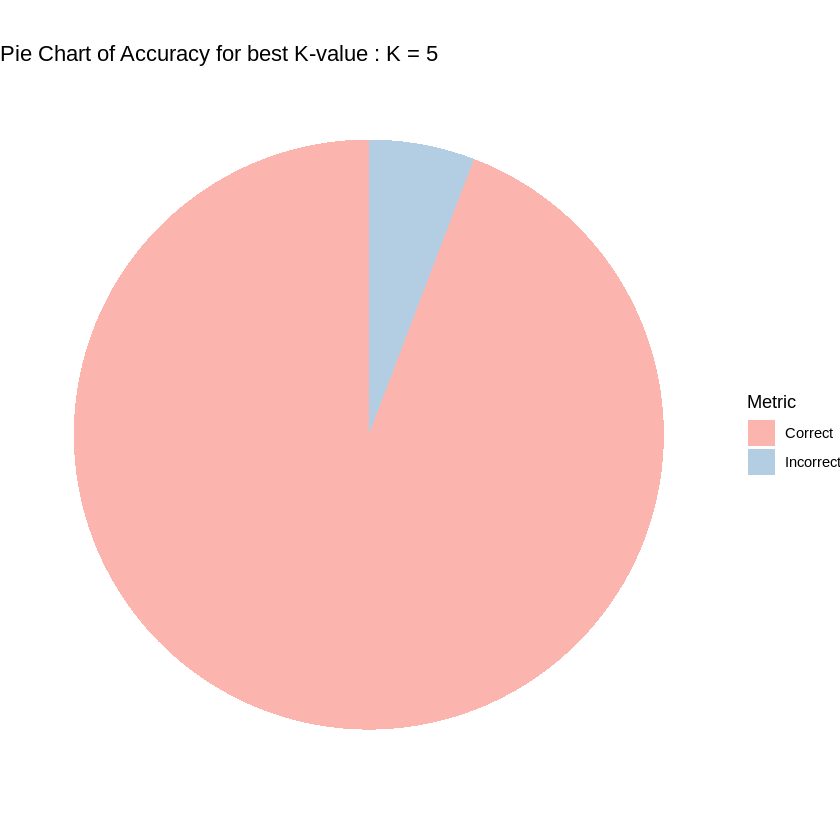

In [50]:
data_k_5 <- data.frame(
  Metric = c("Correct", "Incorrect"),
  Value = c(0.9063000, 1 - 0.9063000)
)


# Create a pie chart
k5_accuracy <- ggplot(data_k_1, aes(x = "", y = Value, fill = Metric)) +
                  geom_bar(stat = "identity", width = 1) +
                  coord_polar(theta = "y") +
                  theme_void() +
                  scale_fill_brewer(palette = "Pastel1") +
                  labs(title = "Pie Chart of Accuracy for best K-value : K = 5")
k5_accuracy

In [ ]:
# bg_grid <- seq(min(diabetes_tidy$blood_glucose_level),
#                 max(diabetes_tidy$blood_glucose_level),
#                 length.out = 100)
# hb_grid <- seq(min(diabetes_tidy$HbA1c_level),
#                 max(diabetes_tidy$HbA1c_level),
#                 length.out = 100)
# asgrid <- as_tibble(expand.grid(blood_glucose_level = bg_grid,
#                                 HbA1c_level = hb_grid))
# knn_fit <- workflow() |>
#             add_recipe() |>
            
# knnPredGrid <- predict(knn_fit, asgrid)
# prediction_table <- bind_cols(knnPredGrid, asgrid) |>
#   rename(Class = .pred_class)
# wkflw_plot <-
#   ggplot() +
#   geom_point(data = diabetes_tidy,
#              mapping = aes(x = blood_glucose_level,
#                            y = HbA1c_level,
#                            color = diabetes),
#              alpha = 0.75) +
#   geom_point(data = prediction_table,
#              mapping = aes(x = blood_glucose_level,
#                            y = HbA1c_level,
#                            color = diabetes),
#              alpha = 0.02,
#              size = 5) +
#   labs(color = "Diabetes",
#        x = "Blood glucose level",
#        y = "HbA1c level") +
#   scale_color_manual(values = c("darkorange", "steelblue")) +
#   theme(text = element_text(size = 12))

# wkflw_plot

## Discussion:

### Expected Outcomes and Significance:

Through our analysis, we expect to find that **higher values for age, BMI, HbA1C level, and blood glucose level, will be associated with an increased likelihood of being at risk for diabetes**. This study provides valuable insights for early diabetes detection, especially in patients who are at higher risk. Public health facilities can use this data to have specific preventive measures tailored towards high-risk populations. In the future, this study can be utilized to predict an individual’s likelihood of developing diabetes and identify the key risk factors associated with the condition.


**Future Questions:**
* What is the most influential variable that affects the likelihood of developing diabetes?
* What is the increased risk for elderly individuals when it comes to diabetes?

## References:
* Gojka Roglic. (2016). WHO Global report on diabetes: A summary. International Journal of Noncommunicable Diseases, 1(1), 3–3. https://doi.org/10.4103/2468-8827.184853
* Mustafa, M. (2023). Diabetes prediction dataset. Kaggle.com. https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset
* LeBlanc, A. G., Yong Jun Gao, McRae, L., & Pelletier, C. (2019). At-a-glance - Twenty years of diabetes surveillance using the Canadian Chronic Disease Surveillance System. Health Promotion and Chronic Disease Prevention in Canada, 39(11), 306–309. https://doi.org/10.24095/hpcdp.39.11.03
* Saeedi, P., Petersohn, I., Paraskevi Salpea, Belma Malanda, Suvi Karuranga, Unwin, N., Colagiuri, S., Guariguata, L., Motala, A. A., Ogurtsova, K., Shaw, J. E., Bright, D., & Williams, R. (2019). Global and regional diabetes prevalence estimates for 2019 and projections for 2030 and 2045: Results from the International Diabetes Federation Diabetes Atlas, 9th edition. Diabetes Research and Clinical Practice, 157, 107843–107843. https://doi.org/10.1016/j.diabres.2019.107843
* Wang, L., Li, X., Wang, Z., Bancks, M. P., Carnethon, M. R., Greenland, P., Ying Qing Feng, Wang, H., & Zhong, V. W. (2021). Trends in Prevalence of Diabetes and Control of Risk Factors in Diabetes Among US Adults, 1999-2018. JAMA, 326(8), 704–704. https://doi.org/10.1001/jama.2021.9883

